# Baseline Results for Multi-modal Approaches

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM1D, BatchNormalization, Bidirectional, Dropout, PReLU
from tensorflow.keras import models
from tensorflow.keras.initializers import Constant

from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import StackEnsemble
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
accuracies = []
aucs = []
model_names = ['1.1 Bidirectional LSTM', '1.1 CNN+LSTM', '1.1 Convolutional LSTM', '1.1 RCNN (Recurrent CNN)', '1.2 Bidirectional LSTM', '1.2 CNN+LSTM', '1.2 Convolutional LSTM', '1.2 RCNN (Recurrent CNN)']

In [3]:
def load_file(file, prediction_type):
    df = pd.read_csv(file, header=0)
    labels = df[prediction_type]
    df = df.drop(columns=['pain_area', 'pain_level'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df.to_numpy(), labels

def load_dataset(input_filepath, prediction_type, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

## 1. Create Model Architectures (Uni-modal approaches / Ensemble members)

### Bidirectional LSTM Model

In [4]:
def get_biConvLSTM(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(Bidirectional(ConvLSTM1D(filters=64, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features))))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

### CNN+LSTM Model

In [5]:
def get_CNN(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

### Convolutional LSTM Model

In [6]:
def get_convLSTM(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

### RCNN (Recurrent CNN) Model

In [7]:
def get_RCNN(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(1, n_length, n_features)))
    model.add(BatchNormalization())
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(BatchNormalization())
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
       optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not a good idea because face modality is missing about half the times?

### 1.1 Pain area prediction

#### Method to concatenate the datasets (skeleton + action units)

In [8]:
def apply_early_fusion(input_filepath, prediction_type):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_area')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 5)
(81, 1, 350, 48) (81, 5)


In [10]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### KFold CV

In [11]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
epochs, batch_size = 50, 68

#### Bidirectional LSTM Model

Epoch 1/50
6/6 - 6s - loss: 265.7050 - accuracy: 0.2893 - auc_1: 0.5645 - val_loss: 60.0885 - val_accuracy: 0.5337 - val_auc_1: 0.7086 - 6s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 28.7427 - accuracy: 0.5365 - auc_1: 0.7275 - val_loss: 3.1156 - val_accuracy: 0.4157 - val_auc_1: 0.7045 - 2s/epoch - 274ms/step
Epoch 3/50
6/6 - 2s - loss: 2.5854 - accuracy: 0.2556 - auc_1: 0.5764 - val_loss: 2.3663 - val_accuracy: 0.2303 - val_auc_1: 0.5208 - 2s/epoch - 275ms/step
Epoch 4/50
6/6 - 2s - loss: 1.5661 - accuracy: 0.1994 - auc_1: 0.6565 - val_loss: 2.7402 - val_accuracy: 0.2303 - val_auc_1: 0.7215 - 2s/epoch - 275ms/step
Epoch 5/50
6/6 - 2s - loss: 1.5430 - accuracy: 0.2079 - auc_1: 0.7357 - val_loss: 2.8849 - val_accuracy: 0.5281 - val_auc_1: 0.7193 - 2s/epoch - 277ms/step


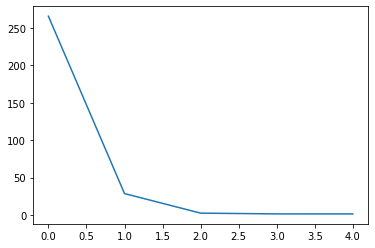

Epoch 1/50
6/6 - 6s - loss: 263.2722 - accuracy: 0.3343 - auc_2: 0.5809 - val_loss: 154.6673 - val_accuracy: 0.5787 - val_auc_2: 0.7367 - 6s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 79.9865 - accuracy: 0.3876 - auc_2: 0.6394 - val_loss: 14.1365 - val_accuracy: 0.5674 - val_auc_2: 0.7354 - 2s/epoch - 282ms/step
Epoch 3/50
6/6 - 2s - loss: 6.4246 - accuracy: 0.4916 - auc_2: 0.7351 - val_loss: 3.6455 - val_accuracy: 0.2247 - val_auc_2: 0.5965 - 2s/epoch - 287ms/step
Epoch 4/50
6/6 - 2s - loss: 2.3856 - accuracy: 0.2669 - auc_2: 0.6137 - val_loss: 1.8524 - val_accuracy: 0.4944 - val_auc_2: 0.5593 - 2s/epoch - 283ms/step
Epoch 5/50
6/6 - 2s - loss: 1.6893 - accuracy: 0.5197 - auc_2: 0.5977 - val_loss: 1.7562 - val_accuracy: 0.5730 - val_auc_2: 0.7287 - 2s/epoch - 283ms/step
Epoch 6/50
6/6 - 2s - loss: 1.5979 - accuracy: 0.5562 - auc_2: 0.7266 - val_loss: 1.7437 - val_accuracy: 0.5730 - val_auc_2: 0.7311 - 2s/epoch - 279ms/step
Epoch 7/50
6/6 - 2s - loss: 1.5885 - accuracy: 0.5534 - auc_2

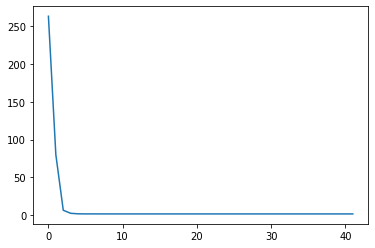

Epoch 1/50
6/6 - 6s - loss: 155.2165 - accuracy: 0.3258 - auc_3: 0.5796 - val_loss: 38.7329 - val_accuracy: 0.5618 - val_auc_3: 0.7261 - 6s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 11.0589 - accuracy: 0.4494 - auc_3: 0.7217 - val_loss: 2.3149 - val_accuracy: 0.1854 - val_auc_3: 0.5174 - 2s/epoch - 279ms/step
Epoch 3/50
6/6 - 2s - loss: 1.7160 - accuracy: 0.2163 - auc_3: 0.6158 - val_loss: 2.2029 - val_accuracy: 0.1742 - val_auc_3: 0.6824 - 2s/epoch - 280ms/step
Epoch 4/50
6/6 - 2s - loss: 1.7544 - accuracy: 0.4101 - auc_3: 0.7090 - val_loss: 2.0088 - val_accuracy: 0.5562 - val_auc_3: 0.6904 - 2s/epoch - 282ms/step
Epoch 5/50
6/6 - 2s - loss: 1.6616 - accuracy: 0.5618 - auc_3: 0.7197 - val_loss: 1.7467 - val_accuracy: 0.5618 - val_auc_3: 0.7007 - 2s/epoch - 278ms/step
Epoch 6/50
6/6 - 2s - loss: 1.5767 - accuracy: 0.5590 - auc_3: 0.7220 - val_loss: 1.6714 - val_accuracy: 0.5618 - val_auc_3: 0.7008 - 2s/epoch - 281ms/step
Epoch 7/50
6/6 - 2s - loss: 1.5665 - accuracy: 0.5618 - auc_3: 

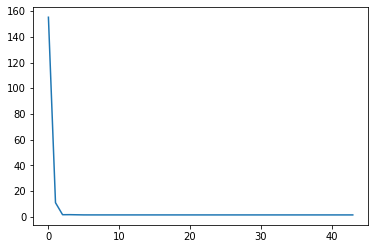

In [13]:
model1 = get_biConvLSTM(n_length, n_features, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model1 = get_biConvLSTM(n_features, n_length, n_outputs)
    history = train(model1, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [14]:
loss, accuracy, auc = model1.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 48.148%

AUC: 0.7768


#### CNN+LSTM Model 

Epoch 1/50
6/6 - 2s - loss: 1.4519 - accuracy: 0.4635 - auc_5: 0.6749 - val_loss: 1.3507 - val_accuracy: 0.5337 - val_auc_5: 0.7346 - 2s/epoch - 369ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2806 - accuracy: 0.5702 - auc_5: 0.7589 - val_loss: 1.3226 - val_accuracy: 0.5337 - val_auc_5: 0.7346 - 342ms/epoch - 57ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2559 - accuracy: 0.5702 - auc_5: 0.7663 - val_loss: 1.2942 - val_accuracy: 0.5337 - val_auc_5: 0.7879 - 341ms/epoch - 57ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2364 - accuracy: 0.5702 - auc_5: 0.7968 - val_loss: 1.2770 - val_accuracy: 0.5337 - val_auc_5: 0.7883 - 345ms/epoch - 57ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2256 - accuracy: 0.5702 - auc_5: 0.7973 - val_loss: 1.2636 - val_accuracy: 0.5337 - val_auc_5: 0.7879 - 343ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2183 - accuracy: 0.5702 - auc_5: 0.7934 - val_loss: 1.2552 - val_accuracy: 0.5337 - val_auc_5: 0.7879 - 345ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 1.2127 - accuracy: 0.5702 

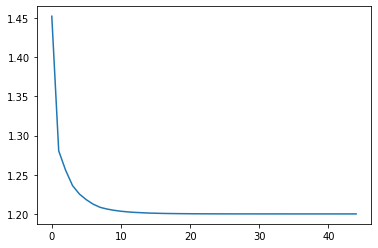

Epoch 1/50
6/6 - 3s - loss: 1.4306 - accuracy: 0.3904 - auc_6: 0.7233 - val_loss: 1.2766 - val_accuracy: 0.5787 - val_auc_6: 0.7775 - 3s/epoch - 431ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2674 - accuracy: 0.5478 - auc_6: 0.7944 - val_loss: 1.2076 - val_accuracy: 0.5787 - val_auc_6: 0.8088 - 401ms/epoch - 67ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2311 - accuracy: 0.5478 - auc_6: 0.8008 - val_loss: 1.1917 - val_accuracy: 0.5787 - val_auc_6: 0.8090 - 360ms/epoch - 60ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2207 - accuracy: 0.5478 - auc_6: 0.7974 - val_loss: 1.1816 - val_accuracy: 0.5787 - val_auc_6: 0.8090 - 336ms/epoch - 56ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2107 - accuracy: 0.5478 - auc_6: 0.8014 - val_loss: 1.1762 - val_accuracy: 0.5787 - val_auc_6: 0.8090 - 337ms/epoch - 56ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2041 - accuracy: 0.5478 - auc_6: 0.8040 - val_loss: 1.1737 - val_accuracy: 0.5787 - val_auc_6: 0.8090 - 341ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 1.2007 - accuracy: 0.5478 

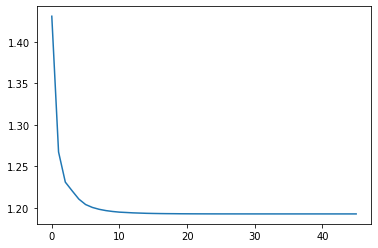

Epoch 1/50
6/6 - 2s - loss: 1.4136 - accuracy: 0.3511 - auc_7: 0.7507 - val_loss: 1.3780 - val_accuracy: 0.5618 - val_auc_7: 0.7799 - 2s/epoch - 377ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3009 - accuracy: 0.5562 - auc_7: 0.8000 - val_loss: 1.2618 - val_accuracy: 0.5618 - val_auc_7: 0.7803 - 341ms/epoch - 57ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2235 - accuracy: 0.5562 - auc_7: 0.8086 - val_loss: 1.2228 - val_accuracy: 0.5618 - val_auc_7: 0.7979 - 349ms/epoch - 58ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2074 - accuracy: 0.5562 - auc_7: 0.8098 - val_loss: 1.2119 - val_accuracy: 0.5618 - val_auc_7: 0.7979 - 341ms/epoch - 57ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2056 - accuracy: 0.5562 - auc_7: 0.8009 - val_loss: 1.2194 - val_accuracy: 0.5618 - val_auc_7: 0.7901 - 358ms/epoch - 60ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2004 - accuracy: 0.5562 - auc_7: 0.8011 - val_loss: 1.2148 - val_accuracy: 0.5618 - val_auc_7: 0.7901 - 345ms/epoch - 58ms/step


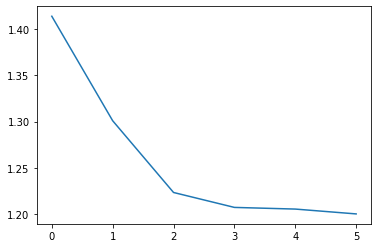

In [15]:
model2 = get_CNN(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model2 = get_CNN(n_features, n_length, n_outputs)
    history = train(model2, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [16]:
loss, accuracy, auc = model2.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.8009


#### Convolutional LSTM Model

Epoch 1/50
6/6 - 4s - loss: 140.2477 - accuracy: 0.2416 - auc_9: 0.5319 - val_loss: 38.1131 - val_accuracy: 0.5281 - val_auc_9: 0.7079 - 4s/epoch - 585ms/step
Epoch 2/50
6/6 - 1s - loss: 13.7091 - accuracy: 0.4354 - auc_9: 0.6958 - val_loss: 3.0324 - val_accuracy: 0.0506 - val_auc_9: 0.3973 - 949ms/epoch - 158ms/step
Epoch 3/50
6/6 - 1s - loss: 1.8691 - accuracy: 0.1938 - auc_9: 0.4874 - val_loss: 1.9465 - val_accuracy: 0.4944 - val_auc_9: 0.6565 - 1s/epoch - 168ms/step
Epoch 4/50
6/6 - 1s - loss: 1.5561 - accuracy: 0.5787 - auc_9: 0.7414 - val_loss: 1.8303 - val_accuracy: 0.5112 - val_auc_9: 0.7012 - 899ms/epoch - 150ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5608 - accuracy: 0.5787 - auc_9: 0.7485 - val_loss: 1.7883 - val_accuracy: 0.5112 - val_auc_9: 0.7026 - 901ms/epoch - 150ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5572 - accuracy: 0.5815 - auc_9: 0.7494 - val_loss: 1.7658 - val_accuracy: 0.5225 - val_auc_9: 0.7034 - 894ms/epoch - 149ms/step
Epoch 7/50
6/6 - 1s - loss: 1.5537 - accuracy: 0

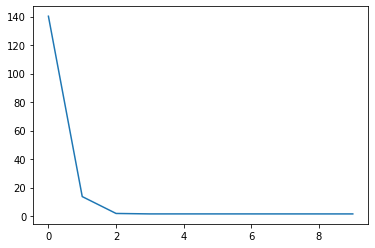

Epoch 1/50
6/6 - 4s - loss: 81.4975 - accuracy: 0.2921 - auc_10: 0.5682 - val_loss: 6.8132 - val_accuracy: 0.5393 - val_auc_10: 0.7408 - 4s/epoch - 583ms/step
Epoch 2/50
6/6 - 1s - loss: 4.2633 - accuracy: 0.5140 - auc_10: 0.6684 - val_loss: 1.6005 - val_accuracy: 0.5618 - val_auc_10: 0.7231 - 966ms/epoch - 161ms/step
Epoch 3/50
6/6 - 1s - loss: 1.5949 - accuracy: 0.5449 - auc_10: 0.7187 - val_loss: 1.6022 - val_accuracy: 0.5787 - val_auc_10: 0.7268 - 918ms/epoch - 153ms/step
Epoch 4/50
6/6 - 1s - loss: 1.5963 - accuracy: 0.5534 - auc_10: 0.7181 - val_loss: 1.5983 - val_accuracy: 0.5787 - val_auc_10: 0.7184 - 980ms/epoch - 163ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5890 - accuracy: 0.5506 - auc_10: 0.7297 - val_loss: 1.5945 - val_accuracy: 0.5787 - val_auc_10: 0.7681 - 918ms/epoch - 153ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5816 - accuracy: 0.5534 - auc_10: 0.7869 - val_loss: 1.5902 - val_accuracy: 0.5730 - val_auc_10: 0.7936 - 1s/epoch - 192ms/step
Epoch 7/50
6/6 - 1s - loss: 1.5731 - ac

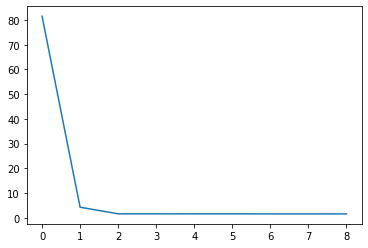

Epoch 1/50
6/6 - 4s - loss: 167.4202 - accuracy: 0.3174 - auc_11: 0.5787 - val_loss: 128.6980 - val_accuracy: 0.5393 - val_auc_11: 0.7115 - 4s/epoch - 682ms/step
Epoch 2/50
6/6 - 1s - loss: 65.3308 - accuracy: 0.4073 - auc_11: 0.6717 - val_loss: 24.7578 - val_accuracy: 0.5449 - val_auc_11: 0.7443 - 1s/epoch - 199ms/step
Epoch 3/50
6/6 - 1s - loss: 15.7779 - accuracy: 0.2444 - auc_11: 0.5833 - val_loss: 11.3765 - val_accuracy: 0.5449 - val_auc_11: 0.7694 - 955ms/epoch - 159ms/step
Epoch 4/50
6/6 - 1s - loss: 5.7461 - accuracy: 0.5506 - auc_11: 0.7619 - val_loss: 4.1297 - val_accuracy: 0.5225 - val_auc_11: 0.7522 - 1s/epoch - 189ms/step
Epoch 5/50
6/6 - 1s - loss: 2.2060 - accuracy: 0.4831 - auc_11: 0.7530 - val_loss: 2.3775 - val_accuracy: 0.5618 - val_auc_11: 0.6557 - 1s/epoch - 228ms/step
Epoch 6/50
6/6 - 1s - loss: 1.7558 - accuracy: 0.5281 - auc_11: 0.6601 - val_loss: 2.1127 - val_accuracy: 0.5169 - val_auc_11: 0.5882 - 1s/epoch - 173ms/step
Epoch 7/50
6/6 - 1s - loss: 1.6886 - accu

In [17]:
model3 = get_convLSTM(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model3 = get_convLSTM(n_features, n_length, n_outputs)
    history = train(model3, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model3.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 49.383%

AUC: 0.718


#### RCNN (Recurrent CNN) Model

Epoch 1/50
6/6 - 2s - loss: 18.5499 - accuracy: 0.3539 - auc_99: 0.6218 - val_loss: 371.0449 - val_accuracy: 0.5337 - val_auc_99: 0.7086 - 2s/epoch - 351ms/step
Epoch 2/50
6/6 - 1s - loss: 10.3834 - accuracy: 0.5309 - auc_99: 0.7163 - val_loss: 120.1853 - val_accuracy: 0.1742 - val_auc_99: 0.4904 - 920ms/epoch - 153ms/step
Epoch 3/50
6/6 - 1s - loss: 3.9192 - accuracy: 0.3680 - auc_99: 0.6958 - val_loss: 13.4643 - val_accuracy: 0.2360 - val_auc_99: 0.5534 - 951ms/epoch - 158ms/step
Epoch 4/50
6/6 - 1s - loss: 2.3693 - accuracy: 0.3427 - auc_99: 0.7066 - val_loss: 15.6078 - val_accuracy: 0.5281 - val_auc_99: 0.7139 - 941ms/epoch - 157ms/step
Epoch 5/50
6/6 - 1s - loss: 1.9674 - accuracy: 0.5281 - auc_99: 0.8043 - val_loss: 17.8011 - val_accuracy: 0.5337 - val_auc_99: 0.7086 - 920ms/epoch - 153ms/step


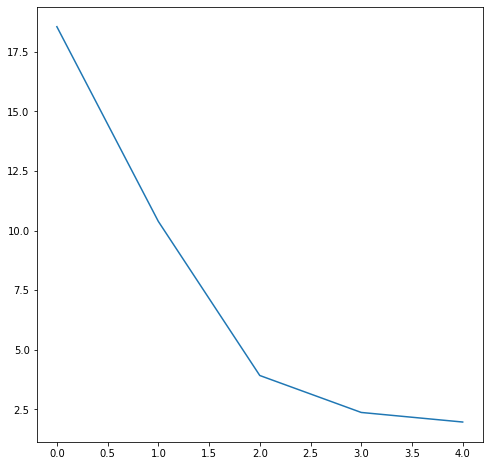

Epoch 1/50
6/6 - 2s - loss: 11.5258 - accuracy: 0.3848 - auc_100: 0.6508 - val_loss: 282.3927 - val_accuracy: 0.1742 - val_auc_100: 0.4838 - 2s/epoch - 308ms/step
Epoch 2/50
6/6 - 1s - loss: 6.1994 - accuracy: 0.4466 - auc_100: 0.7086 - val_loss: 214.9577 - val_accuracy: 0.5787 - val_auc_100: 0.7367 - 907ms/epoch - 151ms/step
Epoch 3/50
6/6 - 1s - loss: 3.9196 - accuracy: 0.4831 - auc_100: 0.7585 - val_loss: 62.6624 - val_accuracy: 0.2022 - val_auc_100: 0.5386 - 908ms/epoch - 151ms/step
Epoch 4/50
6/6 - 1s - loss: 2.9488 - accuracy: 0.4944 - auc_100: 0.7964 - val_loss: 112.6633 - val_accuracy: 0.0506 - val_auc_100: 0.4066 - 927ms/epoch - 154ms/step
Epoch 5/50
6/6 - 1s - loss: 2.5277 - accuracy: 0.5421 - auc_100: 0.8260 - val_loss: 54.3847 - val_accuracy: 0.1124 - val_auc_100: 0.4534 - 922ms/epoch - 154ms/step
Epoch 6/50
6/6 - 1s - loss: 1.8344 - accuracy: 0.6124 - auc_100: 0.8739 - val_loss: 40.9604 - val_accuracy: 0.4888 - val_auc_100: 0.7219 - 927ms/epoch - 155ms/step
Epoch 7/50
6/6 

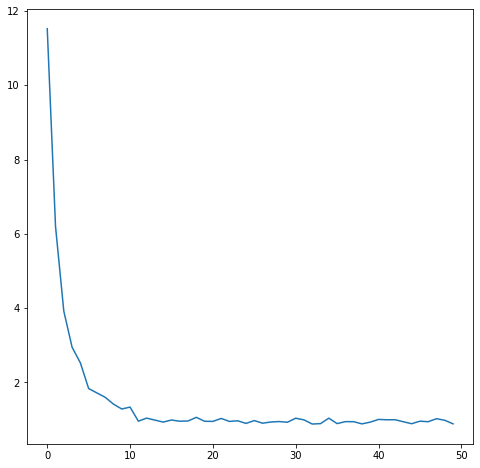

Epoch 1/50
6/6 - 2s - loss: 8.4714 - accuracy: 0.3596 - auc_101: 0.6704 - val_loss: 236.6652 - val_accuracy: 0.1966 - val_auc_101: 0.4979 - 2s/epoch - 308ms/step
Epoch 2/50
6/6 - 1s - loss: 6.3765 - accuracy: 0.4494 - auc_101: 0.7224 - val_loss: 95.9041 - val_accuracy: 0.5449 - val_auc_101: 0.7218 - 919ms/epoch - 153ms/step
Epoch 3/50
6/6 - 1s - loss: 4.4929 - accuracy: 0.4607 - auc_101: 0.7494 - val_loss: 59.2404 - val_accuracy: 0.4438 - val_auc_101: 0.7056 - 1s/epoch - 172ms/step
Epoch 4/50
6/6 - 1s - loss: 3.3758 - accuracy: 0.5478 - auc_101: 0.8190 - val_loss: 24.5885 - val_accuracy: 0.4551 - val_auc_101: 0.7061 - 927ms/epoch - 154ms/step
Epoch 5/50
6/6 - 1s - loss: 2.6914 - accuracy: 0.4747 - auc_101: 0.8039 - val_loss: 27.1968 - val_accuracy: 0.2191 - val_auc_101: 0.5403 - 921ms/epoch - 153ms/step
Epoch 6/50
6/6 - 1s - loss: 2.1236 - accuracy: 0.6264 - auc_101: 0.8503 - val_loss: 17.6889 - val_accuracy: 0.5618 - val_auc_101: 0.7319 - 931ms/epoch - 155ms/step
Epoch 7/50
6/6 - 1s -

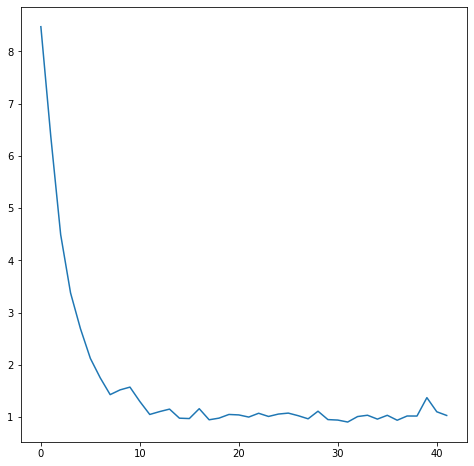

In [ ]:
model4 = get_RCNN(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model4 = get_RCNN(n_features, n_length, n_outputs)
    history = train(model4, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model4.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 45.679%

AUC: 0.7421


### 1.2 Pain level prediction

#### Concatenate datasets (fusion stage)

In [ ]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_area')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 5)
(81, 1, 350, 48) (81, 5)


In [ ]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### Bidirectional LSTM Model

Epoch 1/50
6/6 - 8s - loss: 795.4510 - accuracy: 0.3343 - auc_17: 0.5845 - val_loss: 511.5229 - val_accuracy: 0.5337 - val_auc_17: 0.7086 - 8s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 270.4899 - accuracy: 0.4494 - auc_17: 0.6791 - val_loss: 65.1297 - val_accuracy: 0.1629 - val_auc_17: 0.4908 - 2s/epoch - 268ms/step
Epoch 3/50
6/6 - 2s - loss: 24.4328 - accuracy: 0.3848 - auc_17: 0.6456 - val_loss: 12.2439 - val_accuracy: 0.3596 - val_auc_17: 0.6093 - 2s/epoch - 270ms/step
Epoch 4/50
6/6 - 2s - loss: 10.1184 - accuracy: 0.4017 - auc_17: 0.6730 - val_loss: 5.5153 - val_accuracy: 0.2079 - val_auc_17: 0.6570 - 2s/epoch - 268ms/step
Epoch 5/50
6/6 - 2s - loss: 4.3386 - accuracy: 0.3764 - auc_17: 0.6810 - val_loss: 1.9048 - val_accuracy: 0.4326 - val_auc_17: 0.7596 - 2s/epoch - 268ms/step
Epoch 6/50
6/6 - 2s - loss: 2.0375 - accuracy: 0.3680 - auc_17: 0.7286 - val_loss: 1.5979 - val_accuracy: 0.3989 - val_auc_17: 0.7219 - 2s/epoch - 269ms/step
Epoch 7/50
6/6 - 2s - loss: 1.6779 - accuracy

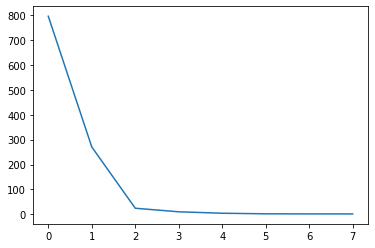

Epoch 1/50
6/6 - 7s - loss: 321.9539 - accuracy: 0.3989 - auc_18: 0.6238 - val_loss: 45.8499 - val_accuracy: 0.2303 - val_auc_18: 0.5375 - 7s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 32.2166 - accuracy: 0.3624 - auc_18: 0.6118 - val_loss: 20.2525 - val_accuracy: 0.3371 - val_auc_18: 0.6032 - 2s/epoch - 264ms/step
Epoch 3/50
6/6 - 2s - loss: 13.7871 - accuracy: 0.2640 - auc_18: 0.5503 - val_loss: 6.1930 - val_accuracy: 0.5169 - val_auc_18: 0.7153 - 2s/epoch - 261ms/step
Epoch 4/50
6/6 - 2s - loss: 4.0164 - accuracy: 0.5337 - auc_18: 0.7587 - val_loss: 3.8563 - val_accuracy: 0.1404 - val_auc_18: 0.6056 - 2s/epoch - 260ms/step
Epoch 5/50
6/6 - 2s - loss: 2.9843 - accuracy: 0.2584 - auc_18: 0.6729 - val_loss: 2.4822 - val_accuracy: 0.5337 - val_auc_18: 0.7779 - 2s/epoch - 262ms/step
Epoch 6/50
6/6 - 2s - loss: 2.1592 - accuracy: 0.5421 - auc_18: 0.8111 - val_loss: 1.9728 - val_accuracy: 0.5618 - val_auc_18: 0.7986 - 2s/epoch - 265ms/step
Epoch 7/50
6/6 - 2s - loss: 1.7117 - accuracy: 0.

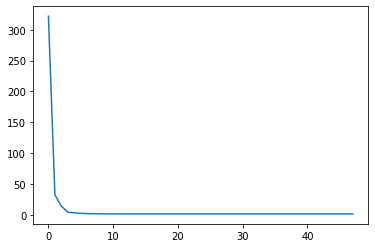

Epoch 1/50
6/6 - 8s - loss: 576.5263 - accuracy: 0.2107 - auc_19: 0.5067 - val_loss: 79.9629 - val_accuracy: 0.5618 - val_auc_19: 0.7261 - 8s/epoch - 1s/step
Epoch 2/50
6/6 - 2s - loss: 51.9987 - accuracy: 0.5169 - auc_19: 0.7087 - val_loss: 27.6608 - val_accuracy: 0.1910 - val_auc_19: 0.5616 - 2s/epoch - 310ms/step
Epoch 3/50
6/6 - 2s - loss: 13.7302 - accuracy: 0.3792 - auc_19: 0.6731 - val_loss: 9.3551 - val_accuracy: 0.4551 - val_auc_19: 0.7343 - 2s/epoch - 279ms/step
Epoch 4/50
6/6 - 2s - loss: 4.5613 - accuracy: 0.4045 - auc_19: 0.7178 - val_loss: 5.1802 - val_accuracy: 0.2360 - val_auc_19: 0.6248 - 2s/epoch - 307ms/step
Epoch 5/50
6/6 - 2s - loss: 2.6692 - accuracy: 0.1798 - auc_19: 0.6186 - val_loss: 4.2341 - val_accuracy: 0.3539 - val_auc_19: 0.6138 - 2s/epoch - 310ms/step
Epoch 6/50
6/6 - 2s - loss: 2.5325 - accuracy: 0.3848 - auc_19: 0.6260 - val_loss: 3.6487 - val_accuracy: 0.4438 - val_auc_19: 0.6238 - 2s/epoch - 289ms/step
Epoch 7/50
6/6 - 2s - loss: 2.2690 - accuracy: 0.

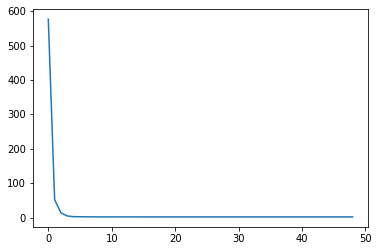

In [ ]:
model1 = get_biConvLSTM(n_length, n_features, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model1 = get_biConvLSTM(n_features, n_length, n_outputs)
    history = train(model1, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model1.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 37.037%

AUC: 0.696


#### CNN+LSTM Model

Epoch 1/50
6/6 - 2s - loss: 1.2936 - accuracy: 0.5590 - auc_21: 0.7849 - val_loss: 1.2471 - val_accuracy: 0.5337 - val_auc_21: 0.7896 - 2s/epoch - 370ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2145 - accuracy: 0.5702 - auc_21: 0.7988 - val_loss: 1.2249 - val_accuracy: 0.5337 - val_auc_21: 0.7879 - 344ms/epoch - 57ms/step
Epoch 3/50
6/6 - 0s - loss: 1.1993 - accuracy: 0.5702 - auc_21: 0.7874 - val_loss: 1.2046 - val_accuracy: 0.5337 - val_auc_21: 0.7971 - 348ms/epoch - 58ms/step
Epoch 4/50
6/6 - 0s - loss: 1.1878 - accuracy: 0.5702 - auc_21: 0.8008 - val_loss: 1.1997 - val_accuracy: 0.5337 - val_auc_21: 0.8062 - 344ms/epoch - 57ms/step
Epoch 5/50
6/6 - 0s - loss: 1.1868 - accuracy: 0.5702 - auc_21: 0.7978 - val_loss: 1.2031 - val_accuracy: 0.5337 - val_auc_21: 0.8006 - 343ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 1.1880 - accuracy: 0.5702 - auc_21: 0.7969 - val_loss: 1.1976 - val_accuracy: 0.5337 - val_auc_21: 0.8006 - 344ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1847 - accur

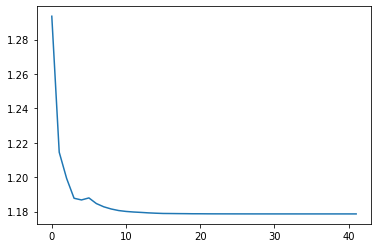

Epoch 1/50
6/6 - 3s - loss: 1.6683 - accuracy: 0.1208 - auc_22: 0.5256 - val_loss: 1.4810 - val_accuracy: 0.1742 - val_auc_22: 0.6391 - 3s/epoch - 434ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3756 - accuracy: 0.4410 - auc_22: 0.7420 - val_loss: 1.2548 - val_accuracy: 0.5787 - val_auc_22: 0.8085 - 349ms/epoch - 58ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2588 - accuracy: 0.5478 - auc_22: 0.8091 - val_loss: 1.2055 - val_accuracy: 0.5787 - val_auc_22: 0.8084 - 348ms/epoch - 58ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2307 - accuracy: 0.5478 - auc_22: 0.8015 - val_loss: 1.1837 - val_accuracy: 0.5787 - val_auc_22: 0.8087 - 358ms/epoch - 60ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2143 - accuracy: 0.5478 - auc_22: 0.7993 - val_loss: 1.1759 - val_accuracy: 0.5787 - val_auc_22: 0.8084 - 350ms/epoch - 58ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2062 - accuracy: 0.5478 - auc_22: 0.8004 - val_loss: 1.1722 - val_accuracy: 0.5787 - val_auc_22: 0.8083 - 349ms/epoch - 58ms/step
Epoch 7/50
6/6 - 0s - loss: 1.2010 - accur

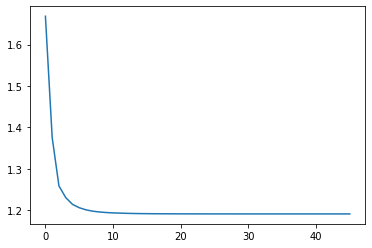

Epoch 1/50
6/6 - 3s - loss: 1.3880 - accuracy: 0.4860 - auc_23: 0.7452 - val_loss: 1.2747 - val_accuracy: 0.5618 - val_auc_23: 0.8051 - 3s/epoch - 461ms/step
Epoch 2/50
6/6 - 0s - loss: 1.2656 - accuracy: 0.5562 - auc_23: 0.8060 - val_loss: 1.2963 - val_accuracy: 0.5618 - val_auc_23: 0.7963 - 400ms/epoch - 67ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2697 - accuracy: 0.5562 - auc_23: 0.7969 - val_loss: 1.2490 - val_accuracy: 0.5618 - val_auc_23: 0.7963 - 424ms/epoch - 71ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2334 - accuracy: 0.5562 - auc_23: 0.8080 - val_loss: 1.2257 - val_accuracy: 0.5618 - val_auc_23: 0.7963 - 354ms/epoch - 59ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2138 - accuracy: 0.5562 - auc_23: 0.8044 - val_loss: 1.2127 - val_accuracy: 0.5618 - val_auc_23: 0.7963 - 345ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2025 - accuracy: 0.5562 - auc_23: 0.8069 - val_loss: 1.2066 - val_accuracy: 0.5618 - val_auc_23: 0.7963 - 347ms/epoch - 58ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1969 - accur

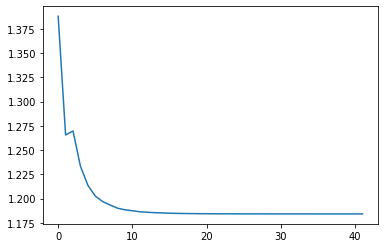

In [ ]:
model2 = get_CNN(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model2 = get_CNN(n_features, n_length, n_outputs)
    history = train(model2, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model2.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.7994


#### Convolutional LSTM Model

Epoch 1/50
6/6 - 4s - loss: 274.8132 - accuracy: 0.4073 - auc_25: 0.6371 - val_loss: 157.1431 - val_accuracy: 0.3989 - val_auc_25: 0.6354 - 4s/epoch - 662ms/step
Epoch 2/50
6/6 - 1s - loss: 76.9539 - accuracy: 0.3989 - auc_25: 0.6459 - val_loss: 14.7110 - val_accuracy: 0.2303 - val_auc_25: 0.5422 - 877ms/epoch - 146ms/step
Epoch 3/50
6/6 - 1s - loss: 8.1401 - accuracy: 0.2219 - auc_25: 0.5626 - val_loss: 1.7666 - val_accuracy: 0.0843 - val_auc_25: 0.5053 - 873ms/epoch - 145ms/step
Epoch 4/50
6/6 - 1s - loss: 1.7393 - accuracy: 0.0534 - auc_25: 0.4993 - val_loss: 1.6406 - val_accuracy: 0.5056 - val_auc_25: 0.5012 - 861ms/epoch - 144ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5968 - accuracy: 0.5787 - auc_25: 0.5143 - val_loss: 1.6348 - val_accuracy: 0.5169 - val_auc_25: 0.4979 - 867ms/epoch - 145ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5777 - accuracy: 0.5758 - auc_25: 0.6520 - val_loss: 1.6518 - val_accuracy: 0.5225 - val_auc_25: 0.6965 - 857ms/epoch - 143ms/step
Epoch 7/50
6/6 - 1s - loss: 1.5

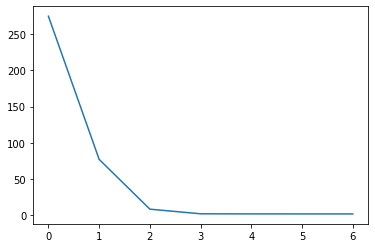

Epoch 1/50
6/6 - 3s - loss: 118.2832 - accuracy: 0.2725 - auc_26: 0.5449 - val_loss: 42.1169 - val_accuracy: 0.5787 - val_auc_26: 0.7361 - 3s/epoch - 545ms/step
Epoch 2/50
6/6 - 1s - loss: 20.8627 - accuracy: 0.3539 - auc_26: 0.6261 - val_loss: 3.1675 - val_accuracy: 0.2303 - val_auc_26: 0.5928 - 978ms/epoch - 163ms/step
Epoch 3/50
6/6 - 1s - loss: 1.9516 - accuracy: 0.2388 - auc_26: 0.6123 - val_loss: 1.8195 - val_accuracy: 0.2191 - val_auc_26: 0.6869 - 960ms/epoch - 160ms/step
Epoch 4/50
6/6 - 1s - loss: 1.6403 - accuracy: 0.4298 - auc_26: 0.6961 - val_loss: 1.7301 - val_accuracy: 0.5843 - val_auc_26: 0.7189 - 990ms/epoch - 165ms/step
Epoch 5/50
6/6 - 1s - loss: 1.6126 - accuracy: 0.5421 - auc_26: 0.7130 - val_loss: 1.6778 - val_accuracy: 0.5843 - val_auc_26: 0.7138 - 941ms/epoch - 157ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5913 - accuracy: 0.5449 - auc_26: 0.7152 - val_loss: 1.6523 - val_accuracy: 0.5843 - val_auc_26: 0.7109 - 917ms/epoch - 153ms/step
Epoch 7/50
6/6 - 1s - loss: 1.585

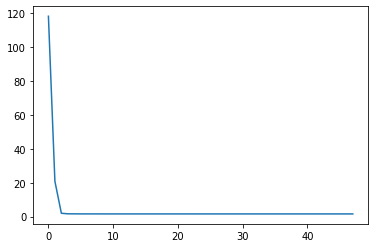

Epoch 1/50
6/6 - 4s - loss: 135.5407 - accuracy: 0.2612 - auc_27: 0.5410 - val_loss: 33.8219 - val_accuracy: 0.5618 - val_auc_27: 0.7261 - 4s/epoch - 616ms/step
Epoch 2/50
6/6 - 1s - loss: 14.8435 - accuracy: 0.5365 - auc_27: 0.7028 - val_loss: 4.4482 - val_accuracy: 0.2247 - val_auc_27: 0.6536 - 898ms/epoch - 150ms/step
Epoch 3/50
6/6 - 1s - loss: 2.6499 - accuracy: 0.2472 - auc_27: 0.7194 - val_loss: 2.6304 - val_accuracy: 0.5618 - val_auc_27: 0.7123 - 872ms/epoch - 145ms/step
Epoch 4/50
6/6 - 1s - loss: 1.6337 - accuracy: 0.5590 - auc_27: 0.7369 - val_loss: 1.8853 - val_accuracy: 0.5618 - val_auc_27: 0.7292 - 879ms/epoch - 146ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5754 - accuracy: 0.5590 - auc_27: 0.7570 - val_loss: 1.8647 - val_accuracy: 0.5674 - val_auc_27: 0.7302 - 876ms/epoch - 146ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5677 - accuracy: 0.5562 - auc_27: 0.7563 - val_loss: 1.8451 - val_accuracy: 0.5674 - val_auc_27: 0.7285 - 871ms/epoch - 145ms/step
Epoch 7/50
6/6 - 1s - loss: 1.558

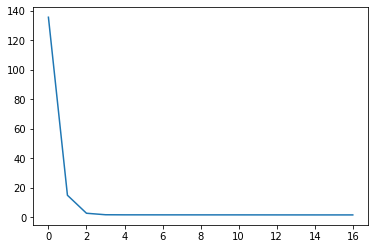

In [ ]:
model3 = get_convLSTM(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model3 = get_convLSTM(n_features, n_length, n_outputs)
    history = train(model3, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model3.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 46.914%

AUC: 0.7357


### RCNN (Recurrent CNN) Model

Epoch 1/50
6/6 - 4s - loss: 1.2924 - accuracy: 0.5056 - auc_29: 0.7664 - val_loss: 1.2224 - val_accuracy: 0.5337 - val_auc_29: 0.8060 - 4s/epoch - 661ms/step
Epoch 2/50
6/6 - 1s - loss: 1.1597 - accuracy: 0.5702 - auc_29: 0.8262 - val_loss: 1.2248 - val_accuracy: 0.5337 - val_auc_29: 0.8121 - 1s/epoch - 181ms/step
Epoch 3/50
6/6 - 1s - loss: 1.1203 - accuracy: 0.5702 - auc_29: 0.8404 - val_loss: 1.1897 - val_accuracy: 0.5337 - val_auc_29: 0.8068 - 1s/epoch - 214ms/step
Epoch 4/50
6/6 - 1s - loss: 1.0991 - accuracy: 0.5702 - auc_29: 0.8482 - val_loss: 1.1792 - val_accuracy: 0.5337 - val_auc_29: 0.8114 - 1s/epoch - 187ms/step
Epoch 5/50
6/6 - 1s - loss: 1.0813 - accuracy: 0.5730 - auc_29: 0.8541 - val_loss: 1.1608 - val_accuracy: 0.5337 - val_auc_29: 0.8274 - 1s/epoch - 177ms/step
Epoch 6/50
6/6 - 1s - loss: 1.0679 - accuracy: 0.5758 - auc_29: 0.8585 - val_loss: 1.1584 - val_accuracy: 0.5337 - val_auc_29: 0.8296 - 1s/epoch - 175ms/step
Epoch 7/50
6/6 - 1s - loss: 1.0555 - accuracy: 0.575

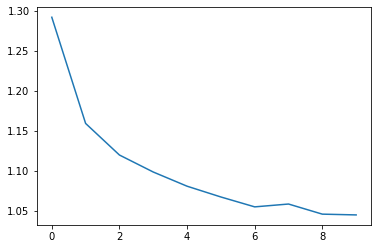

Epoch 1/50
6/6 - 3s - loss: 1.3456 - accuracy: 0.4410 - auc_30: 0.7518 - val_loss: 1.1821 - val_accuracy: 0.5787 - val_auc_30: 0.8075 - 3s/epoch - 515ms/step
Epoch 2/50
6/6 - 1s - loss: 1.1639 - accuracy: 0.5478 - auc_30: 0.8289 - val_loss: 1.1668 - val_accuracy: 0.5787 - val_auc_30: 0.8183 - 1s/epoch - 190ms/step
Epoch 3/50
6/6 - 1s - loss: 1.1297 - accuracy: 0.5506 - auc_30: 0.8363 - val_loss: 1.1741 - val_accuracy: 0.5787 - val_auc_30: 0.7989 - 1s/epoch - 174ms/step
Epoch 4/50
6/6 - 1s - loss: 1.1130 - accuracy: 0.5646 - auc_30: 0.8433 - val_loss: 1.1661 - val_accuracy: 0.5787 - val_auc_30: 0.8122 - 1s/epoch - 174ms/step
Epoch 5/50
6/6 - 1s - loss: 1.0848 - accuracy: 0.5646 - auc_30: 0.8550 - val_loss: 1.1693 - val_accuracy: 0.5787 - val_auc_30: 0.8062 - 1s/epoch - 172ms/step
Epoch 6/50
6/6 - 1s - loss: 1.0746 - accuracy: 0.5646 - auc_30: 0.8576 - val_loss: 1.1657 - val_accuracy: 0.5787 - val_auc_30: 0.8122 - 1s/epoch - 172ms/step
Epoch 7/50
6/6 - 1s - loss: 1.0571 - accuracy: 0.559

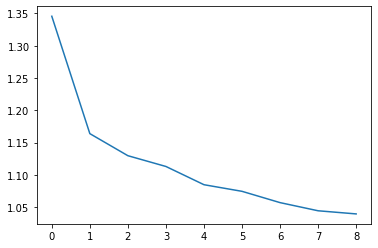

Epoch 1/50
6/6 - 3s - loss: 1.3096 - accuracy: 0.4888 - auc_31: 0.7645 - val_loss: 1.1941 - val_accuracy: 0.5618 - val_auc_31: 0.8101 - 3s/epoch - 509ms/step
Epoch 2/50
6/6 - 1s - loss: 1.1664 - accuracy: 0.5562 - auc_31: 0.8246 - val_loss: 1.1956 - val_accuracy: 0.5618 - val_auc_31: 0.8100 - 1s/epoch - 173ms/step
Epoch 3/50
6/6 - 1s - loss: 1.1336 - accuracy: 0.5562 - auc_31: 0.8370 - val_loss: 1.1912 - val_accuracy: 0.5618 - val_auc_31: 0.8103 - 1s/epoch - 173ms/step
Epoch 4/50
6/6 - 1s - loss: 1.1096 - accuracy: 0.5618 - auc_31: 0.8450 - val_loss: 1.1850 - val_accuracy: 0.5618 - val_auc_31: 0.8122 - 1s/epoch - 173ms/step
Epoch 5/50
6/6 - 1s - loss: 1.0932 - accuracy: 0.5674 - auc_31: 0.8501 - val_loss: 1.1875 - val_accuracy: 0.5618 - val_auc_31: 0.8122 - 1s/epoch - 171ms/step
Epoch 6/50
6/6 - 1s - loss: 1.0792 - accuracy: 0.5674 - auc_31: 0.8555 - val_loss: 1.1811 - val_accuracy: 0.5618 - val_auc_31: 0.8148 - 1s/epoch - 171ms/step
Epoch 7/50
6/6 - 1s - loss: 1.0707 - accuracy: 0.567

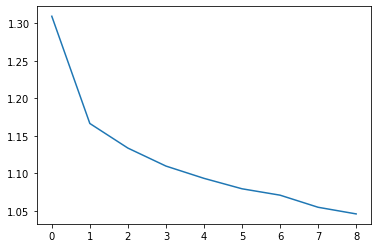

In [ ]:
model4 = get_RCNN(n_features, n_length, n_outputs)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model4 = get_RCNN(n_features, n_length, n_outputs)
    history = train(model4, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [ ]:
loss, accuracy, auc = model4.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.8013


## 2. Late Fusion - Fusion is performed at decision level

I consider late fusion by ...

Fusion mechanisms/schemes used:

- (Unweighted) Majority voting. If the combination has a tie, we use the class probability (confidence score) to break the tie.

- Weighted voting

- Weighted sum

### 2.1 Pain area prediction

### 2.2 Pain level prediction

## 3. Ensemble - Meta-Learner approaches

I consider ensemble approaches by integrating outputs of individual trained classifiers (one per modality, same output label as the label at the end). Each ensemble member provides prediction scores that are aggregated to train a meta-learner (stacking ensemble). The ensemble is in charge of producing
the final classification. 

A drawback with the ensemble approach is that I only work with two modalities, so there's no ensemble if one modality is missing. It would have been more interesting with 3+ modalities. Additionally, I can't use models that require different input shapes (=slightly limiting).

### 3.1 Pain area prediction

#### Dataset

In [ ]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'skeleton')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 38) (534, 5)
(81, 1, 350, 38) (81, 5)


In [ ]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### Stacking Ensemble

In [ ]:
# member1 = KerasMember(name="model1", keras_model=model1,
                             # train_batches=(X_train, y_train),
                             # val_batches=(X_val, y_val))

In [ ]:
# member2 = KerasMember(name="model2", keras_model=model2,
                             # train_batches=(X_train, y_train),
                            # val_batches=(X_val, y_val))

In [ ]:
#stack = StackEnsemble()
#stack.add_member(member1)
#stack.add_member(member2)

In [ ]:
#stack.fit()

In [ ]:
#stack.describe()

#### Dirichlet Markov Ensemble

In [ ]:
#dirichletEnsemble = DirichletEnsemble(N=2000 * 2)
#dirichletEnsemble.add_member(member1)
#dirichletEnsemble.add_member(member2)

In [ ]:
#dirichletEnsemble.fit()

In [ ]:
#dirichletEnsemble.describe()

### 3.2 Pain level prediction

#### Dataset

## 4. Results

In [ ]:
def show_results(first, last):
    plt.rcParams['figure.figsize'] = (8,8)
    x = np.arange(len(model_names[first:last]))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies[first:last], width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs[first:last], width, label='AUC * 100')

    ax.set_ylim(0, 100)
    ax.set_xticks(x, model_names[first:last])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

### Early fusion - Pain area prediction 

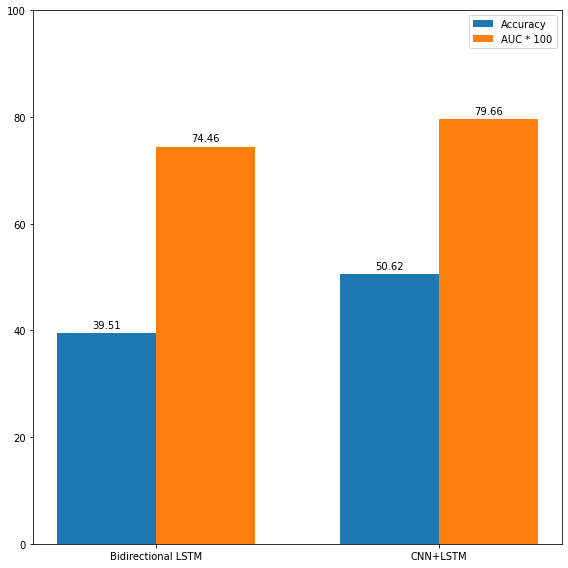

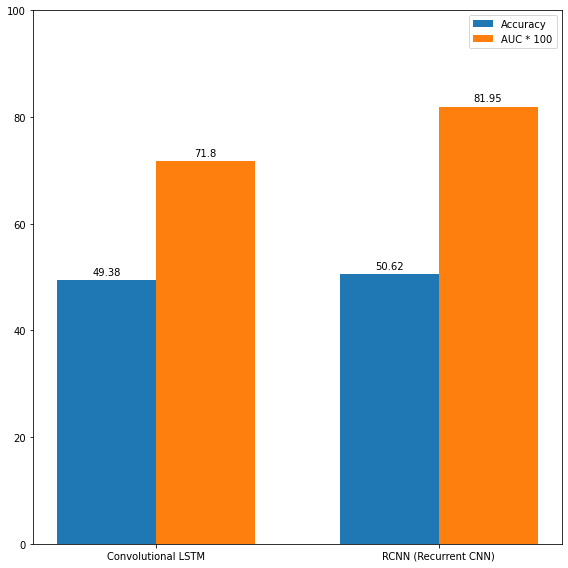

In [ ]:
show_results(0, 2)
show_results(2, 4)

### Early fusion - Pain level prediction 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

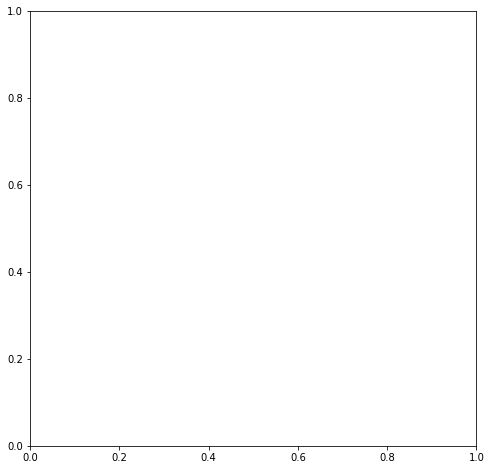

In [ ]:
show_results(4, 6)
show_results(6, 8)

### Late fusion - Pain area prediction

### Late fusion - Pain level prediction

### Ensemble approaches - Pain area prediction

### Ensemble approaches - Pain level prediction